# **# 3.**

**구글 드라이브와 연동하여 구글 드라이브에서 데이터 가져오기**
- 첨부한 archive 데이터를 자신의 구글 드라이브에 업로드
- yout_path 변수에 자신이 구글 드라이브에 저장한 경로를 입력

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

your_path = "/content/drive/MyDrive/Colab Notebooks/SAI 문제풀이/archive/pokemon.csv"
hdata = pd.read_csv(your_path)

In [ ]:
hdata.sort_values(by='Name', inplace=True)
hdata.reset_index(inplace=True)
hdata.head()

,index,Name,Type1,Type2
0,459,abomasnow,Grass,Ice
1,62,abra,Psychic,NaN
2,358,absol,Dark,NaN
3,616,accelgor,Bug,NaN
4,680,aegislash-blade,Steel,Ghost


**이미지 데이터 전처리 하기**

In [ ]:
import numpy as np
from PIL import Image

pokemon_img = np.empty((0, 120, 120, 3), int)
pokemon_index = np.empty((0), int)

your_img_path = '/content/drive/MyDrive/Colab Notebooks/SAI 문제풀이/archive/images/images/'
path = your_img_path

for num in range(len(hdata)):
  img_name = hdata['Name'][num]

  try:
    im = Image.open(path + '%s.jpg'%(img_name))
    pix = np.array(im)

    if(pix.shape != (120, 120, 3)):
      continue
    pokemon_img = np.append(pokemon_img, np.array([pix]), axis=0)
    pokemon_index = np.append(pokemon_index, num)

  except:
    im = Image.open(path + '%s.png'%(img_name))
    pix = np.array(im)

    if(pix.shape != (120, 120, 4)):
      continue

    for row_index in range(pix.shape[0]):
      for col_index in range(pix.shape[1]):
        if pix[:, :, 3][row_index][col_index] == 0:    # png 데이터의 투명도를 나타내는 부분에서, 포켓몬 이미지를 제외한 배경의 pixel 값을 255로 바꿀 것임
          for i in range(3):
            pix[:, :, i][row_index][col_index] = 255

    pix = pix[:, :, :3] # 투명 부분 버리기
    pokemon_img = np.append(pokemon_img, np.array([pix]), axis=0)
    pokemon_index = np.append(pokemon_index, num)

pokemon_type = hdata.iloc[pokemon_index, 2]

이미지 데이터를 전처리한 결과 얻은 데이터는 아래와 같음<br/>
이미지 데이터: pokemon_img<br/>
타겟 데이터: pokemon_type

**1. 6장의 draw_fruits 함수를 이용하여 포켓몬 사진 100개를 출력  (1점)**

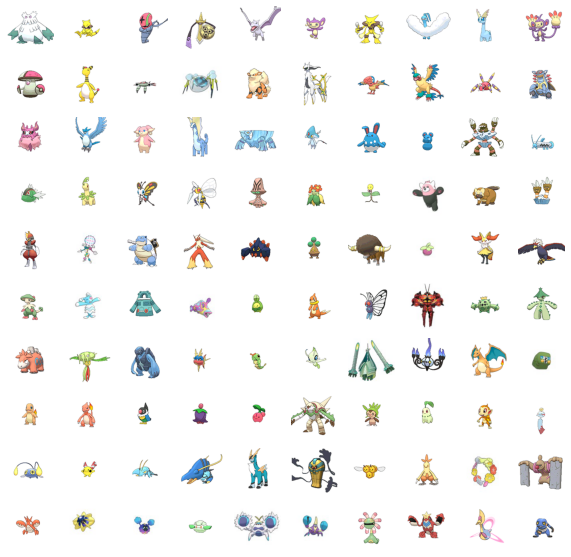

In [ ]:
def draw(arr, ratio=1):
  n = 100   ### 샘플 개수
  rows = int(np.ceil(n/10))   ### 한 줄에 10개씩 이미지 그리기
  cols = n if rows < 2 else 10   ### 행이 1개면 열의 개수는 샘플 개수 -> 그렇지 않으면 10개
  fig, axs = plt.subplots(rows, cols, figsize=(cols*ratio, rows*ratio), squeeze=False)
  for i in range(rows):
    for j in range(cols):
      if i*10 + j < n :
        axs[i,j].imshow(arr[i*10+j], cmap='gray_r')
      axs[i,j].axis('off')
  plt.show()

import matplotlib.pyplot as plt
draw(pokemon_img)

**2. 이미지를 흑백 반전한후 포켓몬 사진 100개를 출력**
- 힌트<br/>
4는 10을 빼서 6으로 바꿀 수 있다<br/>
numpy는 broadcasting 기능을 제공한다

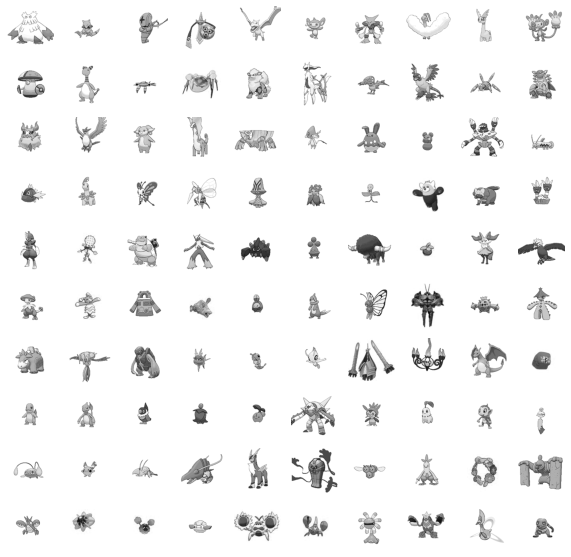

In [ ]:
def draw(arr, ratio=1):
  n = 100   ### 샘플 개수
  rows = int(np.ceil(n/10))   ### 한 줄에 10개씩 이미지 그리기
  cols = n if rows < 2 else 10   ### 행이 1개면 열의 개수는 샘플 개수 -> 그렇지 않으면 10개
  fig, axs = plt.subplots(rows, cols, figsize=(cols*ratio, rows*ratio), squeeze=False)

  for i in range(rows):
    for j in range(cols):
      if i*10 + j < n :
        axs[i,j].imshow(arr[i*10+j], cmap='gray_r')
      axs[i,j].axis('off')
  plt.show()

pokemon_img_grayscaled = np.array([np.mean(255-img, axis=2) for img in pokemon_img])

import matplotlib.pyplot as plt
draw(pokemon_img_grayscaled)

**3. 아래 지시사항을 참고하여 target을 완성**
* pokemon_type 데이터에 있는 데이터 종류를 파악하고 알파벳 순으로 라벨을 '0, 1, 2,...'으로 지정하여 새로운 label을 만드세요

In [ ]:
# tolist() 함수 : pandas의 dataframe -> list 형태로 변경
# set() 함수 : list의 중복되는 문자열 값 지우고, 집합 형태로 만들기
# sort() 함수 : 문자열 알파벳 순서로 정렬
new_pokemon_type = list(set(pokemon_type.tolist()))
new_pokemon_type.sort()

# label 새로
pokemon_type_label = pokemon_type.map(lambda x : new_pokemon_type.index(x))
print(pokemon_type_label)

0       9
1      14
3       0
4      16
5      15
       ..
804     1
805     1
806    13
807     1
808     2
Name: Type1, Length: 610, dtype: int64


**모델 만들기**
아래 지시문을 이행하여 모델을 생성, 훈련 및 평가
- scikit-learn을 이용하여 train_data와 test_data를 0.25 비율로 나누세요 (random_state는 42)
- 훈련에 사용할 이미지 데이터를 0 ~ 1사이의 값으로 바꿔주세요
- 은닉층은 1000개의 노드와 'relu'함수를 이용하여 형성해주세요
- 출력층은 'softmax' 함수를 이용하여 형성해주세요
- 손실함수는 교재에서 배운 크로스엔트로피를 사용해주세요
- epoch는 10으로 설정하고, 훈련에서 정확도가 출력되게 해주세요

In [ ]:
# train_data와 test_data 나누기
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(pokemon_img_grayscaled, pokemon_type_label, test_size = 0.25, random_state=42)

# 훈련에 사용할 이미지 데이터를 0 ~ 1 사이의 값으로
train_scaled = X_train / 255.0
train_scaled = train_scaled.reshape(-1,120*120)

test_scaled = X_test / 255.0
test_scaled = test_scaled.reshape(-1,120*120)

# 모델 만들기
  ## 은닉층 : 1000개의 노드와 'relu' 함수를 이용하여 형성
    ### input_dim : input_shape에 차원이 하나만 있으면, scalar number로 지정
  ## 출력층 : 출력되어야할 pokemon 종류 갯수와 'softmax' 함수를 이용하여 형성
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Dense(1000, activation='relu', input_dim=120*120))
model.add(keras.layers.Dense(len(new_pokemon_type), activation='softmax'))

# 모델 훈련
  ## 손실함수 : 크로스엔트로피 사용
  ## epoch는 10으로 & 정확도 출력
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(train_scaled, Y_train, epochs = 10)

# 모델 평가
model.evaluate(test_scaled, Y_test)

Epoch 1/10
15/15 [==============================] - 1s 49ms/step - loss: 4.1246 - accuracy: 0.0744
Epoch 2/10
15/15 [==============================] - 1s 49ms/step - loss: 2.2801 - accuracy: 0.2976
Epoch 3/10
15/15 [==============================] - 1s 50ms/step - loss: 1.8462 - accuracy: 0.4354
Epoch 4/10
15/15 [==============================] - 1s 48ms/step - loss: 1.4321 - accuracy: 0.6018
Epoch 5/10
15/15 [==============================] - 1s 48ms/step - loss: 1.1023 - accuracy: 0.7330
Epoch 6/10
15/15 [==============================] - 1s 50ms/step - loss: 0.8153 - accuracy: 0.8140
Epoch 7/10
15/15 [==============================] - 1s 51ms/step - loss: 0.6373 - accuracy: 0.8753
Epoch 8/10
15/15 [==============================] - 1s 49ms/step - loss: 0.5096 - accuracy: 0.9059
Epoch 9/10
15/15 [==============================] - 1s 51ms/step - loss: 0.3523 - accuracy: 0.9540
Epoch 10/10
5/5 [==============================] - 0s 17ms/step - loss: 3.7774 - accuracy: 0.1699


[3.777362108230591, 0.16993464529514313]

# **# 5**

혼공이는 이번 주차에 배운 인공신경망을 활용하여 이진분류를 해보고자 합니다. 혼공이는 영화리뷰 데이터를 긍정, 부정으로 나누는 이진 분류를 하고 싶습니다. 이 과정에서 드롭아웃과 콜백을 이용하여 가장 좋은 모델을 만들어보고자 합니다.

1. IMDB 데이터 불러오기

- 자주 사용되는 10000개의 데이터만 사용하도록 제한합니다.

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

#데이터불러오기
(train_input, train_target), (test_input, test_target) = keras.datasets.imdb.load_data(num_words=10000)

2. 원핫 인코딩

- 원핫 인코딩을 통해 신경망에 주입할 데이터를 리스트에서 텐서로 바꿔주세요.

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만들기
    results = np.zeros((len(sequences), dimension))
    ### enumerate() : 객체의 첫 번째 요소부터 번호를 매기는 함수 -> 출력 : (번호, 요소)
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # results[i]의 특정 인덱스만 1로 설정
    return results

train_input = vectorize_sequences(train_input, dimension= 10000)
test_input = vectorize_sequences(test_input, dimension=10000)

3. 검증세트 만들기

- 훈련 세트에서 20%를 사용하여 검증 세트를 만들어주세요.

In [ ]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

4. 인공 신경망 모델 만들기

- 드롭아웃층을 꼭 추가해주세요
- 모델을 만들고 summary() 메서드로 출력해봅시다

In [ ]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Dense(16, activation='relu', input_dim=10000, name='dense_input'))
model.add(keras.layers.Dense(16, activation='relu', name='dense'))
model.add(keras.layers.Dropout(0.3, name='dropout_1'))
model.add(keras.layers.Dense(16, activation='relu', name='dense_1'))
model.add(keras.layers.Dropout(0.3, name='dropout'))
model.add(keras.layers.Dense(1, activation='sigmoid', name='dense_2'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (Dense)         (None, 16)                160016    
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,577
Trainable params: 160,577
Non-tr

5. 컴파일

- 옵티마이저는 RMSprop을 사용해봅시다.
- 이진 분류 문제에 사용되는 손실함수를 사용해주세요.

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

6. 콜백

- ModelCheckpoint 콜백을 사용하여 가장 좋은 모델을 저장합니다.
- earlystopping 콜백을 사용하여 5번 연속 검증 점수가 향상되지 않을 경우 훈련을 중지합니다.
- 몇번째 에포크에서 훈련이 중지되었는지 프린트해서 확인해봅시다.

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_input, train_target, epochs=20, verbose=0, validation_data=(val_input, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

print(early_stopping_cb.stopped_epoch)

6


7. 그래프 그리기

에포크가 증가함에 따른
- 훈련 손실과 검증 손실의 변화를 확인해봅시다.
- 훈련 정확도와 검증 정확도의 변화를 확인해봅시다.

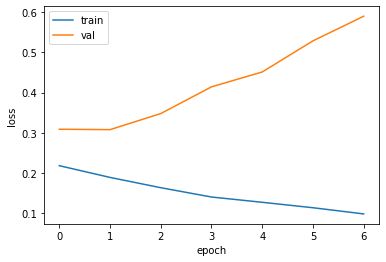

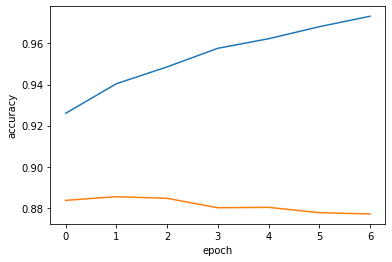

In [ ]:
import matplotlib.pyplot as plt

# 훈련 손실과 검증 손실의 변화 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

# 훈련 정확도와 검증 정확도의 변화 확인
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
